In [1]:
import numpy as np
import matplotlib.pyplot as plt
from circadian.models import Skeldon23
from circadian.lights import LightSchedule

In [2]:
dt = 0.005 # hours
days = 14
lights_on = 6.0
lights_off = 22.0
typical_indoor_lux = 1000.0 # 90.0
time = np.arange(0.0, 24 * days, dt)

# Regular schedule

In [3]:
skeldon_params = {'S0': 0.0, 'mu': 20}

In [4]:
regular_schedule = LightSchedule.Regular(typical_indoor_lux, lights_on=lights_on, lights_off=lights_off)
equilibration_model = Skeldon23(params=skeldon_params)
equilibration_dt = 0.005
equilibration_days = 1
equilibration_time = np.arange(0.0, 24 * equilibration_days, equilibration_dt)
equilibration_light = regular_schedule(equilibration_time)
initial_condition = equilibration_model.equilibrate(equilibration_time, equilibration_light, num_loops=10)

/home/eric/Engineering/Work/circadian/circadian/models.py:427: UserWarning: The model did not equilibrate. Try increasing the number of loops.
  warnings.warn("The model did not equilibrate. Try increasing the number of loops.")


In [5]:
regular_light = regular_schedule(time)
regular_model = Skeldon23(params=skeldon_params)
regular_trajectory = regular_model.integrate(time, initial_condition=initial_condition, input=regular_light) 

## Plot

In [6]:
regular_sleep = regular_model.sleep_state
regular_received_light = regular_model.received_light

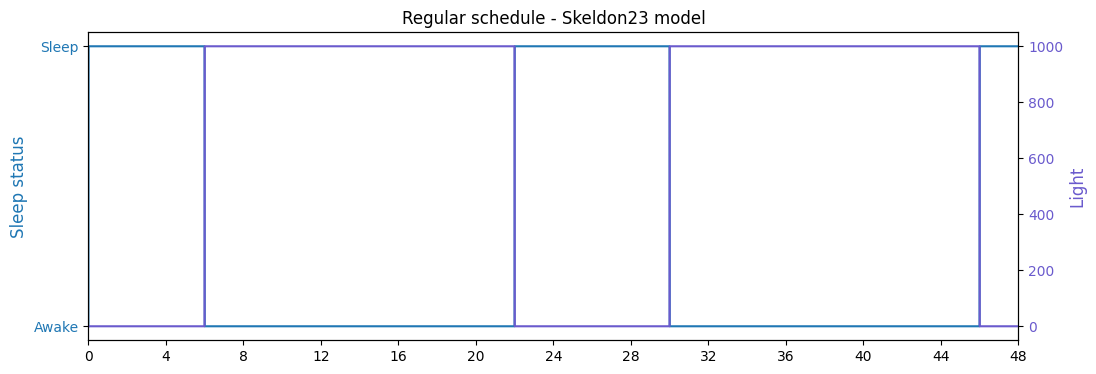

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 4))
# plot light on a twin axis
ax1.plot(time, regular_sleep, label='Regular')
# change y-axis ticks
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Awake', 'Sleep'], color='tab:blue')
ax1.set_ylabel('Sleep status', fontsize=12, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(time, regular_light, 'slateblue')
ax2.set_ylabel('Light', color='slateblue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='slateblue')
plt.title('Regular schedule - Skeldon23 model', fontsize=12)
plt.xlabel('Time (hours)', fontsize=14)
plt.xticks(np.linspace(0, 48, 13))
plt.xlim([0, 48])
plt.show()

In [8]:
def circadian_modulation_of_sleep(model, trajectory):
    # calculate the new sleep state
    x = trajectory.states[:, 0]
    xc = trajectory.states[:, 1]
    linear_term = model.c20 + model.alpha21 * xc + model.alpha22 * x
    quadratic_term = model.beta21 * xc * xc + model.beta22 * xc * x + model.beta23 * x * x
    C = linear_term + quadratic_term
    return C

def H_thresholds(model, trajectory):
    C = circadian_modulation_of_sleep(model, trajectory)
    H_plus = model.H0 + 0.5 * model.Delta + model.ca * C
    H_minus = model.H0 - 0.5 * model.Delta + model.ca * C 
    return H_plus, H_minus

In [9]:
sleep_pressure = regular_trajectory.states[:, 3]
H_plus, H_minus = H_thresholds(regular_model, regular_trajectory)

In [10]:
sleep = regular_sleep
sleep_start = np.where(np.diff(sleep) == 1)[0][0]
sleep_end = np.where(np.diff(sleep) == -1)[0][-1]

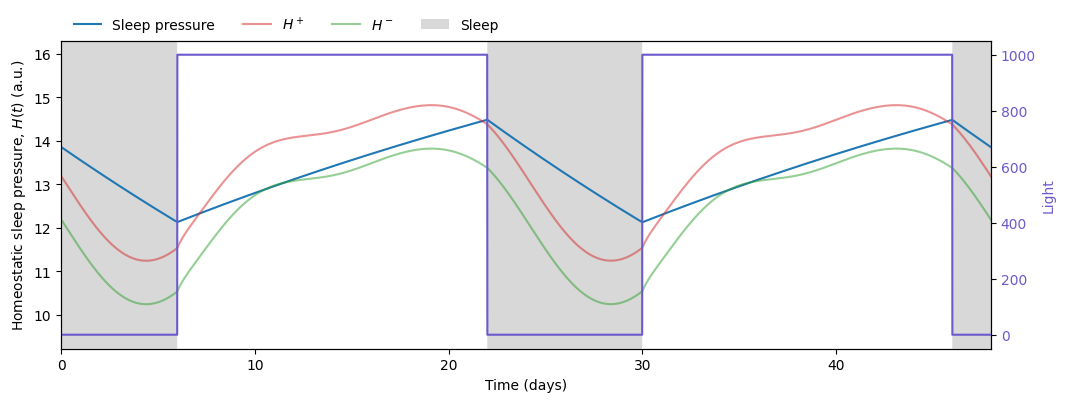

In [11]:
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time, sleep_pressure, label='Sleep pressure')
ax.plot(time, H_plus, color='tab:red', alpha=0.5, label=r'$H^+$')
ax.plot(time, H_minus, color='tab:green', alpha=0.5, label=r'$H^-$')
# twin ax for light
ax2 = ax.twinx()
ax2.plot(time, regular_light, 'slateblue', label='Light')
ax2.set_ylabel('Light', color='slateblue')
ax2.tick_params(axis='y', labelcolor='slateblue')

ax.set_ylabel(r'Homeostatic sleep pressure, $H(t)$ (a.u.)')
ax.set_xlabel('Time (days)')
min_state = 0.9 * min(H_minus)
max_state = 1.1 * max(H_plus)
ax.fill_between(time, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim([0, 48])
ax.set_ylim(min_state, max_state)
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.125), ncol=5, frameon=False)
plt.show()

# Smooth schedule

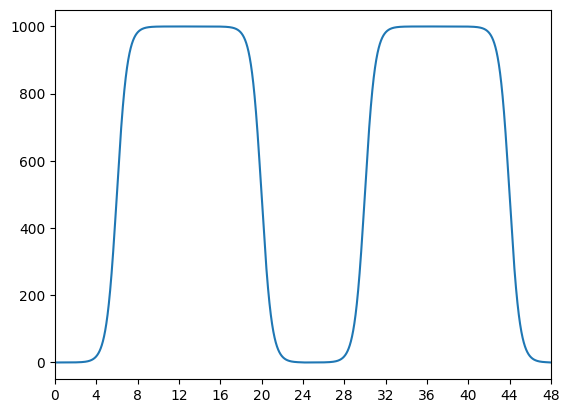

In [12]:
# Smooth equilibration

day_lux = 1000.0
baseline_lux = 0.0
lights_on = 6.0
lights_off = 20.0

def smooth_light(t):
    rise = np.tanh(1.0 * (t - lights_on))
    fall = np.tanh(1.0 * (t - lights_off))
    y = (day_lux / 2.0) * (rise - fall) + baseline_lux
    return y

equilibration_dt = 0.005
equilibration_days = 7
regular_schedule = LightSchedule(smooth_light, period=24.0)
equilibration_time = np.arange(0.0, 24 * equilibration_days, equilibration_dt)
equilibration_light = regular_schedule(equilibration_time)

import matplotlib.pyplot as plt
plt.plot(equilibration_time, equilibration_light)
plt.xticks(np.linspace(0, 48, 13))
plt.xlim([0, 48])
plt.show()

In [13]:

# equilibration_model = Skeldon23()
# initial_condition = equilibration_model.equilibrate(equilibration_time, equilibration_light, num_loops=20)